In [20]:
# Importing the libraries we'll be using for this project
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, RocCurveDisplay,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import  ConfusionMatrixDisplay,precision_score,recall_score
from sklearn.model_selection import learning_curve


In [36]:
# load in database and split as neccessary
df = pd.read_csv('database_prev10days_attemp4.csv')
df = df[df.Diff != 0]
print(df.shape)
# Splitting the training data into appropriate training and validation sets
X = df.drop(columns = ["Diff","date","Unnamed: 0"])
print(df.head(2))
y = df[['Diff']]
y = y.to_numpy().flatten()
weights = compute_class_weight(class_weight='balanced',classes = np.unique(y),y = y)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42,stratify=y)# makes sure train test splitting are the imbalanced by the same amount

(974, 124)
   Unnamed: 0      date  day10_pos_mean_likes  day10_pos_mean_replies  \
0           0  20170112              3.540877                2.980973   
1           1  20170113              2.688410                2.520085   

   day10_pos_mean_retweet  day10_pos_sd  day10_neu_mean_likes  \
0                3.052879     24.444988              2.571007   
1                2.844737     17.050466              5.373914   

   day10_neu_mean_replies  day10_neu_mean_retweet  day10_neu_sd  ...  \
0                2.997780                3.021332     25.364667  ...   
1                5.619566                5.162004     14.922122  ...   

   day1_neu_mean_likes  day1_neu_mean_replies  day1_neu_mean_retweet  \
0             8.028677               8.366872               9.094131   
1             6.780715               7.166920               7.121932   

   day1_neu_sd  day1_neg_mean_likes  day1_neg_mean_replies  \
0    27.128056             0.264051               0.304716   
1    27.058838 

In [13]:
def cv_fit_search(pipeline, param_grid, X_train,y_train,X_test,y_test,cv):
    """ a function to fit the data and do hyper parameter tuning
    Args:
        pipeline: a predefined pipeline
        param grid: a list of parameters that match the pipeline naming convetion
        CV: integer indicating the number of cross validations we want to do
        X_train:X to train on
        y_train: labels for Training Set
        X_test = held out data for final accuacry
        y_test = held out labels
    
    Return
    model: the fitted and hypertuned model,
    
    Prints: AUROC Curve, ACC AUC score of best models, best parameters found

    """
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, verbose=0,n_jobs=-1) # sets cross calidation settings
    grid_search.fit(X_train,y_train.ravel())

    pipeline_preds = grid_search.predict(X_test)
    val_accuracy = accuracy_score(y_test, pipeline_preds)
    val_roc_auc = roc_auc_score(y_test, pipeline_preds)
    f1 = f1_score(y_test, pipeline_preds)
    recall = recall_score(y_test,pipeline_preds)
    precision = precision_score(y_test,pipeline_preds)

    
    print("the best parametes are",grid_search.best_params_)
    print(f'Accuracy Score: {val_accuracy}')
    print(f'ROC AUC Score: {val_roc_auc}') 
    print(f'f1 Score: {f1}') 
    print(f'recall Score: {recall}') 
    print(f'precision Score: {precision}') 

    ConfusionMatrixDisplay.from_predictions(y_test,pipeline_preds)
    plt.show()

    RocCurveDisplay.from_predictions(y_test, pipeline_preds)
    plt.show()
    return grid_search

the best parametes are {'model__criterion': 'entropy', 'model__max_depth': 70, 'model__min_samples_leaf': 3, 'model__min_samples_split': 3, 'model__n_estimators': 60}
Accuracy Score: 0.5286885245901639
ROC AUC Score: 0.5140215403373298
f1 Score: 0.6101694915254238
recall Score: 0.6766917293233082
precision Score: 0.5555555555555556


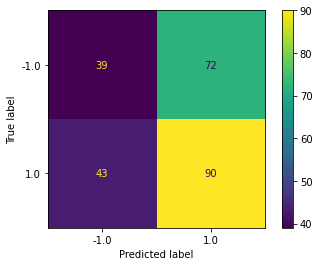

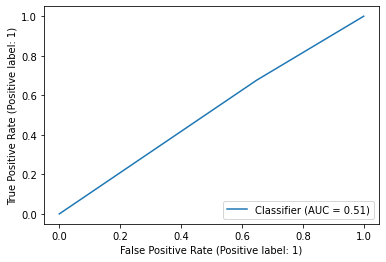

['model/randomforest_pipeline.pkl']

In [37]:
#Create a random forest pipeline
randomforest_pipeline = Pipeline(steps = [
    ('data_scaling', RobustScaler()),
    ('model', RandomForestClassifier(class_weight= "balanced"))
])
randomforest_param_grid = [
    {
        "model__n_estimators": np.arange(30,100,15),
        "model__criterion": ["gini","entropy"],
        "model__max_depth": np.arange(10,100,30),
        "model__min_samples_leaf": [3,6],
        "model__min_samples_split": [3,6]
        
    }
] 
tuned_model = cv_fit_search(randomforest_pipeline,randomforest_param_grid,X_train,y_train,X_val,y_val,10)
joblib.dump(tuned_model, 'model/randomforest_pipeline.pkl')

the best parametes are {'model__l2_regularization': 0, 'model__learning_rate': 0.5, 'model__loss': 'binary_crossentropy'}
Accuracy Score: 0.5
ROC AUC Score: 0.49217638691322907
f1 Score: 0.5579710144927537
recall Score: 0.5789473684210527
precision Score: 0.5384615384615384


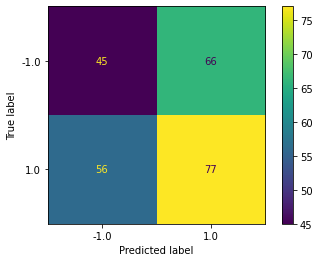

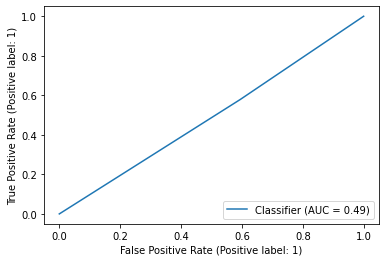

['model/boosting_pipeline.pkl']

In [15]:
# Lets try a boosting model now
# Due to the way boosting works, does not need weights to deal with imbalanced classes
from sklearn.ensemble import HistGradientBoostingClassifier
boostingPipeline = Pipeline(steps = [
    ('data_scaling', RobustScaler()),
    ('model', HistGradientBoostingClassifier())
])

boosting_param_grid = [
    {
        "model__loss": ["binary_crossentropy","auto"],
        "model__learning_rate": [0.01,0.05,0.1,0.5,1],
        "model__l2_regularization": [0,1]
    }
]   
tuned_model = cv_fit_search(boostingPipeline,boosting_param_grid,X_train,y_train,X_val,y_val,10)
joblib.dump(tuned_model, 'model/boosting_pipeline.pkl')

the best parametes are {'model__penalty': 'l2'}
Accuracy Score: 0.4918032786885246
ROC AUC Score: 0.48912822597033123
f1 Score: 0.5267175572519084
recall Score: 0.518796992481203
precision Score: 0.5348837209302325


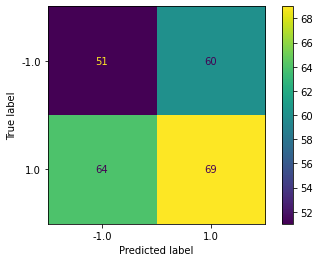

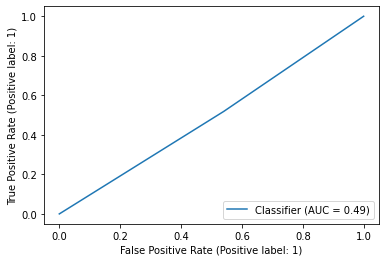

['model/lr_pipeline.pkl']

In [16]:
#logistic Regression with cross validation
from sklearn.linear_model import LogisticRegressionCV
lr_pipeline = Pipeline(steps = [
    ('data_scaling', RobustScaler()),
    ('model', LogisticRegressionCV(solver="liblinear",class_weight="balanced"))#saga solver works for all penalties
])

lr_param_grid = [
    {
        "model__penalty": ['l1', 'l2']
    }
]

tuned_model = cv_fit_search(lr_pipeline,lr_param_grid,X_train,y_train,X_val,y_val,10)
joblib.dump(tuned_model, 'model/lr_pipeline.pkl')

the best parametes are {'model__n_neighbors': 197}
Accuracy Score: 0.5532786885245902
ROC AUC Score: 0.5134796450585924
f1 Score: 0.6997245179063362
recall Score: 0.9548872180451128
precision Score: 0.5521739130434783


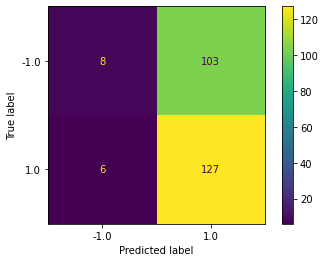

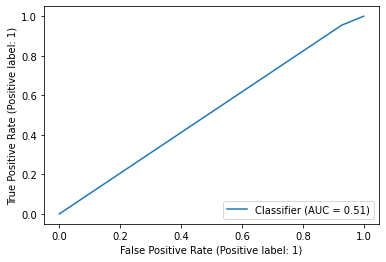

['model/knnc_pipeline.pkl']

In [17]:
#k nearest neighbors classifier
from sklearn.neighbors import KNeighborsClassifier

knnc_pipeline = Pipeline(steps = [
    ('data_scaling', RobustScaler()),
    ('model', KNeighborsClassifier())#10 cross validation
])

knnc_param_grid = [
    {
        "model__n_neighbors": np.arange(1,200)
    }
]

tuned_model = cv_fit_search(knnc_pipeline,knnc_param_grid,X_train,y_train,X_val,y_val,10)

joblib.dump(tuned_model, 'model/knnc_pipeline.pkl')


the best parametes are {'model__kernel': 'poly'}
Accuracy Score: 0.5286885245901639
ROC AUC Score: 0.49390367811420444
f1 Score: 0.670487106017192
recall Score: 0.8796992481203008
precision Score: 0.5416666666666666


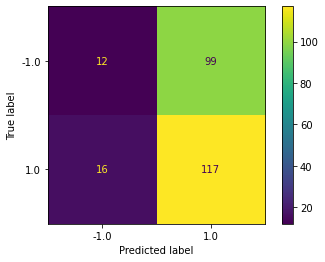

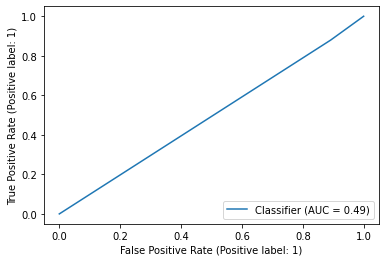

['model/svm_pipeline.pkl']

In [18]:
from sklearn.svm import SVC

svm_pipeline = Pipeline(steps = [
    ('data_scaling', RobustScaler()),
    ('model', SVC(class_weight="balanced"))#10 cross validation
])

svm_param_grid = [
    {
        "model__kernel": ['linear', 'poly', 'rbf']
    }
]

tuned_model = cv_fit_search(svm_pipeline,svm_param_grid,X_train,y_train,X_val,y_val,10)

joblib.dump(tuned_model, 'model/svm_pipeline.pkl')

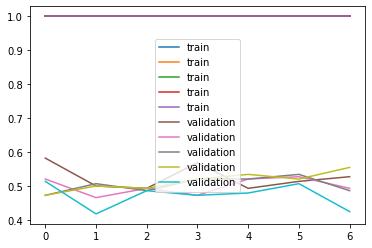

In [35]:
train_sizes, train_scores, valid_scores = learning_curve(randomforest_pipeline, X_train, y_train, train_sizes=np.arange(40,250,30), cv=5)

plt.plot(train_scores,label = "train")
plt.plot(valid_scores,label = "validation")
plt.legend()
plt.show()